<a href="https://colab.research.google.com/github/mtsizh/galaxy-morphology-manifold-learning/blob/main/morphology_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can either upload your own `curated_imgs.zip` or use the following code to download it from our repository.

In [1]:
!wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/curated_dataset/curated_imgs_multipart.zip && echo "HEAD dowloaded" || "ERROR downloading HEAD"

for i in range(1,8):
  !wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/curated_dataset/curated_imgs_multipart.z0{i}  && echo "PART {i} of 7 OK" || "ERROR downloading PART {i}"

print('MERGING PARTS')
!zip -FF curated_imgs_multipart.zip --out curated_imgs.zip > /dev/null && rm curated_imgs_multipart.z* && echo "COMPLETE" || "FAILED"

!unzip -q -o curated_imgs.zip && echo "UNZIPPED" || "FAIL"

HEAD dowloaded
PART 1 of 7 OK
PART 2 of 7 OK
PART 3 of 7 OK
PART 4 of 7 OK
PART 5 of 7 OK
PART 6 of 7 OK
PART 7 of 7 OK
MERGING PARTS
COMPLETE
UNZIPPED


You can process data by LLE creating dataset with reduced dimension. Result will be saved into pickle file, expected size ~30Mb. You can download it if you wish for processing.

Processing takes ~30 min, so you may want to use precomputed results (see the next block of code)

In [7]:
import pandas as pd
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding
from tqdm.auto import tqdm
from PIL import Image
import pickle


# use different class maps to get different plots
class_map = {1: 'round', 2: 'inbetween', 3: 'cigar'}
#class_map = {4: 'edge on', 5: 'edge off'}
#class_map = {6: 'smooth', 7: 'featured'}
n_neighbors = 10
n_components = 138
n_bootstrap_samples = 20000


df = pd.read_parquet('curated_dataset.parquet')
regex_filter = '|'.join(class_map.values())
filtered_df = df[df['class'].str.contains(regex_filter, regex=True)]
bootstrapped_df = filtered_df.sample(n=n_bootstrap_samples)
X = np.zeros((len(bootstrapped_df), 120, 120))
y = np.zeros(len(bootstrapped_df))


for key, val in class_map.items():
  y[bootstrapped_df['class'].str.contains(val, regex=True)] = key

print('LOAD IMAGES')
paths = bootstrapped_df['png_loc'].str.replace('dr5', 'curated_imgs')
with tqdm(total=len(paths)) as progress:
  for idx, file_path in enumerate(paths):
    with Image.open(file_path) as img:
      X[idx,:,:] = np.array(img)
      progress.update()

print('CALCULATE LLE')
X_flattened = X.reshape(X.shape[0], -1)
lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components)
X_embedded = lle.fit_transform(X_flattened)

cname = '_'.join(class_map.values())
out_file = f'{cname}_LLE_{n_components}_neighbours_{n_neighbors}.pkl'.replace(' ', '_')
print('SAVING to: ', out_file)
with open(out_file, 'wb') as f:
  pickle.dump({'X_embedded': X_embedded, 'y': y, 'class_map': class_map}, f)
print('COMPLETE')

LOAD IMAGES


  0%|          | 0/10000 [00:00<?, ?it/s]

CALCULATE LLE
SAVING to:  no_spiral_arms_has_spiral_arms_LLE_138_neighbours_10.pkl
COMPLETE


You can download precomputed embeddings

|filename|dimesions|neighbors|bootstrap|
|---|---|---|---|
edge_on_edge_off_LLE_138_neighbours_10.pkl | 138 | 10 | 20K|
round_inbetween_cigar_LLE_138_neighbours_10.pkl | 138 | 10 | 20K|
smooth_featured_LLE_138_neighbours_10.pkl | 138 | 10 | 20K|



In [9]:
!wget https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/embeddings/edge_on_edge_off_LLE_138_neighbours_10.pkl
!wget https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/embeddings/round_inbetween_cigar_LLE_138_neighbours_10.pkl
!wget https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/embeddings/smooth_featured_LLE_138_neighbours_10.pkl


--2025-02-26 13:50:08--  https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/embeddings/edge_on_edge_off_LLE_138_neighbours_10.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22240267 (21M) [application/octet-stream]
Saving to: ‘edge_on_edge_off_LLE_138_neighbours_10.pkl’

edge_on_edge_off_LL 100%[===================>]  21.21M  --.-KB/s    in 0.1s    

2025-02-26 13:50:09 (143 MB/s) - ‘edge_on_edge_off_LLE_138_neighbours_10.pkl’ saved [22240267/22240267]

--2025-02-26 13:50:09--  https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/embeddings/round_inbetween_cigar_LLE_138_neighbours_10.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199

Train classifier and draw confusion matrix. Data is taken from the appropriate pickle file.

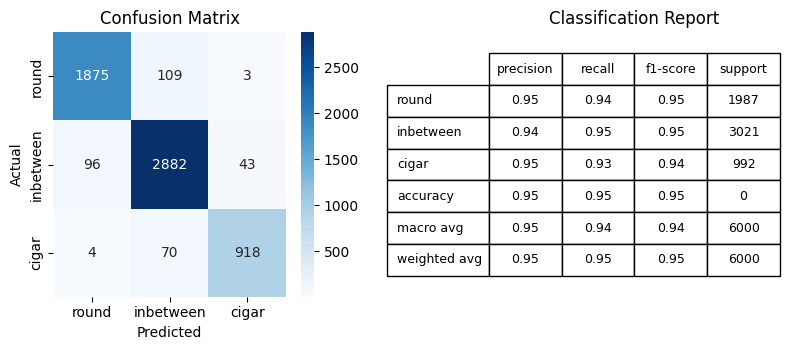

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns


# set correct filename to load embedding data
load_from = 'round_inbetween_cigar_LLE_138_neighbours_10.pkl'


# helper function for visuals
def draw_heatmap_with_info(y_test, y_pred, width, height, clsnames):
    cm = confusion_matrix(y_test, y_pred, labels=list(clsnames.keys()))
    cm_df = pd.DataFrame(cm, index=list(clsnames.values()), columns=list(clsnames.values()))

    class_report = classification_report(y_test, y_pred, output_dict=True, target_names=list(clsnames.values()))
    class_report_df = pd.DataFrame(class_report).transpose()
    class_report_df['support'] = class_report_df['support'].astype(int)

    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    axes[1].axis('off')
    table = axes[1].table(
        cellText=class_report_df.map(lambda x: f"{x:.2f}" if isinstance(x, float) else x).values,
        rowLabels=class_report_df.index,
        colLabels=class_report_df.columns,
        cellLoc="center",
        loc="center",
    )
    table.scale(1, 2)
    axes[1].set_title("Classification Report")
    plt.tight_layout()
    plt.show()


with open(load_from, 'rb') as f:
  data = pickle.load(f)
  X_embedded = data['X_embedded']
  y = data['y']
  class_map = data['class_map']

# Split dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.3, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit multinomial logistic regression
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Generate confusion matrix
draw_heatmap_with_info(y_test, y_pred, width=8, height=3.6, clsnames=class_map)